In [0]:
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

torch.manual_seed(777)  # reproducibility

In [0]:
# hyper-parameters
batch_size = 32
keep_prob = 1 # 0.7

In [0]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


In [0]:
# Display informations about the dataset
print('The training dataset:\t',mnist_train)
print('\nThe testing dataset:\t',mnist_test)

The training dataset:	 Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()

The testing dataset:	 Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()


The CNN architecture we used in this notebook is proposed [ here ](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/index.html)

![Architecture of the CNN…](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

In [0]:
# Implementation of CNN/ConvNet Model using PyTorch (depicted in the picture above)

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# instantiate CNN model
model = CNN()
model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [0]:
for param in model.parameters():
    print(param.size())

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([625, 2048])
torch.Size([625])
torch.Size([10, 625])
torch.Size([10])


In [0]:

learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.LBFGS(params=model.parameters(), lr=learning_rate)
#optimizer.step(closure)


The cross-entropy cost function is defined as follow : 
$\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
= -x[class] + \log\left(\sum_j \exp(x[j])\right)$

In [0]:
print('Training the Deep Learning network ...')
train_cost = []
train_accu = []

training_epochs = 12
total_batch = len(mnist_train) // batch_size

print('Size of the training dataset is {}'.format(mnist_train.data.size()))
print('Size of the testing dataset'.format(mnist_test.data.size()))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded
        optimizer.zero_grad() # <= initialization of the gradients
        
       
        def closure():    
          # forward propagation
          optimizer.zero_grad() 
          hypothesis = model(X)
              
          cost = criterion(hypothesis, Y) # <= compute the loss function
          #print(cost.item())
              # Backward propagation
          cost.backward() # <= compute the gradient of the loss/cost function     
          optimizer.step(closure) # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch
      
    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))
      


print('Learning Finished!')


Training the Deep Learning network ...
Size of the training dataset is torch.Size([60000, 28, 28])
Size of the testing dataset
Batch size is : 32
Total number of batches is : 1875

Total number of epochs is : 12
Epoch= 1,	 batch = 0,	 cost = 2.3193,	 accuracy = 0.09375
Epoch= 1,	 batch = 200,	 cost = 2.3193,	 accuracy = 0.09375
Epoch= 1,	 batch = 400,	 cost = 2.3193,	 accuracy = 0.0625
Epoch= 1,	 batch = 600,	 cost = 2.3193,	 accuracy = 0.1875
Epoch= 1,	 batch = 800,	 cost = 2.3193,	 accuracy = 0.03125
Epoch= 1,	 batch = 1000,	 cost = 2.3193,	 accuracy = 0.0625
Epoch= 1,	 batch = 1200,	 cost = 2.3193,	 accuracy = 0.09375
Epoch= 1,	 batch = 1400,	 cost = 2.3193,	 accuracy = 0.125
Epoch= 1,	 batch = 1600,	 cost = 2.3193,	 accuracy = 0.09375
Epoch= 1,	 batch = 1800,	 cost = 2.3193,	 accuracy = 0.125
[Epoch:    1], averaged cost = 2.31922817
Epoch= 2,	 batch = 0,	 cost = 2.3193,	 accuracy = 0.09375
Epoch= 2,	 batch = 200,	 cost = 2.3193,	 accuracy = 0.125
Epoch= 2,	 batch = 400,	 cost = 2.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7a45a15b70>,
 (0.0, 100.0))

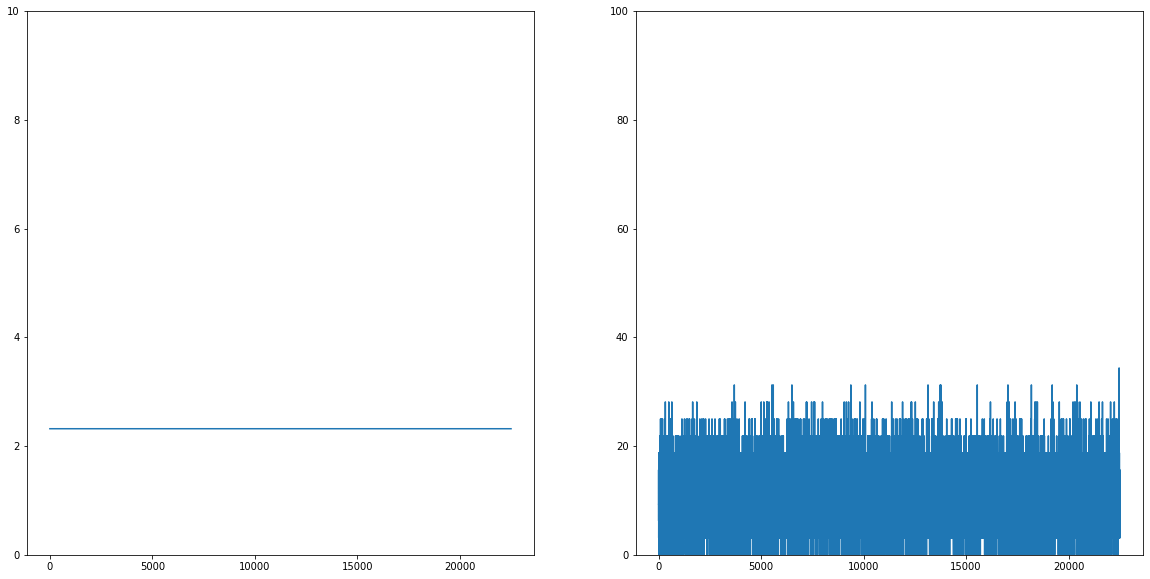

In [0]:
import numpy as np
from matplotlib import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(121), plt.plot(np.arange(len(train_cost)), train_cost), plt.ylim([0,10])
plt.subplot(122), plt.plot(np.arange(len(train_accu)), 100 * torch.as_tensor(train_accu).numpy()), plt.ylim([0,100])



In [0]:
# Test model and check accuracy
model.eval()    # set the model to evaluation mode (dropout=False)

X_test = Variable(mnist_test.data.view(len(mnist_test), 1, 28, 28).float())
Y_test = Variable(mnist_test.targets)

prediction = model(X_test)

# Compute accuracy
pred_Y = torch.max(prediction.data, dim=1)[1]
correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))


Accuracy: 10.09 %


In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics


labels = ['zero' , 'one' , 'two' , 'three' , 'four' , 'five', 'six' , 'seven' , 'eight' , 'nine']

classification_result = metrics.classification_report(Y_test , pred_Y , target_names=labels)
print(classification_result)


              precision    recall  f1-score   support

        zero       0.00      0.00      0.00       980
         one       0.00      0.00      0.00      1135
         two       0.00      0.00      0.00      1032
       three       0.00      0.00      0.00      1010
        four       0.00      0.00      0.00       982
        five       0.00      0.00      0.00       892
         six       0.00      0.00      0.00       958
       seven       0.00      0.00      0.00      1028
       eight       0.00      0.00      0.00       974
        nine       0.10      1.00      0.18      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


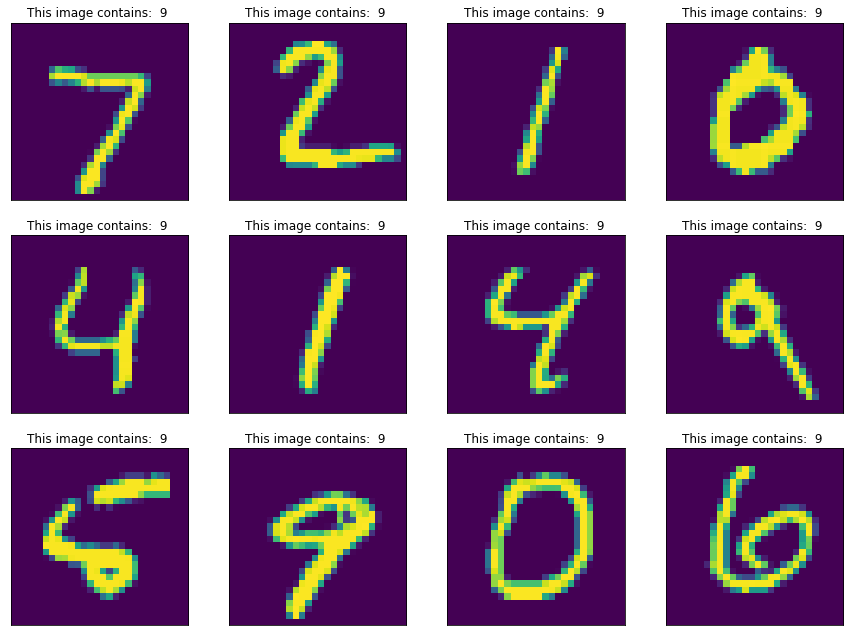

In [0]:
from matplotlib import pylab as plt



plt.figure(figsize=(15,15), facecolor='white')
for i in torch.arange(0,12):
  val, idx = torch.max(prediction, dim=1)
  plt.subplot(4,4,i+1)  
  plt.imshow(X_test[i][0])
  plt.title('This image contains: {0:>2} '.format(idx[i].item()))
  plt.xticks([]), plt.yticks([])
  plt.plt.subplots_adjust()